In [3]:
# Numerical
from jax.numpy import exp, newaxis, mean   # Arithematic
from jax.numpy import array, zeros, arange, where # Array creation routines
from jax.numpy import float64
from jax.numpy import sum as vsum
from jax.numpy.linalg import solve, eig, norm
from jax.lax import scan 
from jax import jit, jacrev, jacfwd, vmap

# Miscellaneous
from functools import partial 
from time import process_time
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter
from ticktack.dormand_prince import odeint as DP5

# Visualisation
import matplotlib.pyplot as plt

In [4]:
def construct_analytic_solution():
    """
    This creates a closure environment that pre-calculates the eigenvalues of the transfer matrix and the coefficients that produce the approriate initial state.
    """
    cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    cbm.compile()

    eigenvalues, eigenvectors = eig(cbm._matrix)
    soln = solve(eigenvectors, cbm._production_coefficients)
    soln = 1 / norm(soln) * soln    # Normalising the impulse 

    @partial(jit, static_argnums=(2, 3, 4))
    def analytic_solution(time, start, area, coeffs=soln, eigenvals=eigenvalues, eigenvecs=eigenvectors):
        """
        This is the analytic solution itself.
        
        Parameters: 
            time: Array -> The time values that the solution is to be evaluated at 
            coeffs: Array -> The coefficients associated with a particular initial condition. 
          
            eigenvals: Array -> The eigenvalues of the transfer matrix used to construct the linear superposition of the eigenfunctions
            eigenvecs: Array[Array] -> The eigenvectors of the transfer matrix used to construct the linear superposition of the eigenfunctions.
        
        Returns:
            Array -> The analytic solution evaluated at times
        """
        @jit
        def sum_util(coeff, eigenval, eigenvec, /, time=time, start=start, area=area):
            return area * coeff * exp(eigenval * (time - start))[:, newaxis] * eigenvec

        impulse = vsum(vmap(sum_util)(coeffs, eigenvals, eigenvecs.T), axis=0)
        return where(time.reshape(time.shape[0], 1) > start, impulse, zeros(impulse.shape))

    return analytic_solution

In [6]:
test = construct_analytic_solution()

In [9]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    with open(filename) as data:
        header = next(data)
        data = array([row.strip().split(" ") for row in data], dtype=float64)
        return data.T


In [10]:
data = load("miyake12.csv")
data = data.at[1].add(mean(data[1, 1:4]))

In [11]:
import matplotlib.pyplot as plt

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/matplotlib-3.5.1-py3.9-linux-x86_64.egg/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


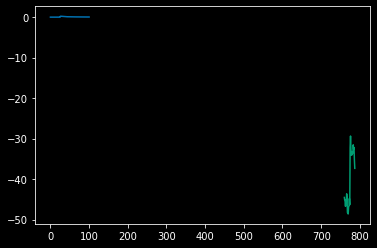

In [11]:
plt.plot(time_out, hi[:, 1])
plt.plot(data[0], data[1])